In [1]:
# Jax and sharding utils
import jax
import jax.numpy as jnp
from jax.experimental import mesh_utils

# Ott 
from ott.data import get_cifar10
from ott.solvers.linear import sinkhorn
from ott.solvers import linear
from ott.geometry import pointcloud
from ott.geometry import costs
from ott.math import utils

# Misc. 
from typing import Optional
import time
import matplotlib.pyplot as plt
import functools

We show in this notebook how calls to a {class}`~ott.solvers.linear.sinkhorn.Sinkhorn` solver can scale to a hundred thousand points (and more) using sharding across multiple GPUs. We start by loading the `CIFAR-10` train fold, originally of size `50k`, duplicated using horizontal flips.

In [ ]:
x, y, label = get_cifar10(sigma=1., gaussian_blur_kernel_size=15, use_flip=True)

This call loads two point-clouds in dimension `3072` of `100k` points each.

In [5]:
x.shape, y.shape

((100000, 3072), (100000, 3072))

The source `x` contains all images. The target `y` contains the same images, to which a blur has been applied. This blurring operation is an optimal transport, meaning that, as shown in {cite}`kassraie:24`, that an optimal transport solver parameterized with a squared-Euclidean cost should match `x` to `y` exactly in that order. In other words, the optimal transport matrix should be the identity divided by `100k`.

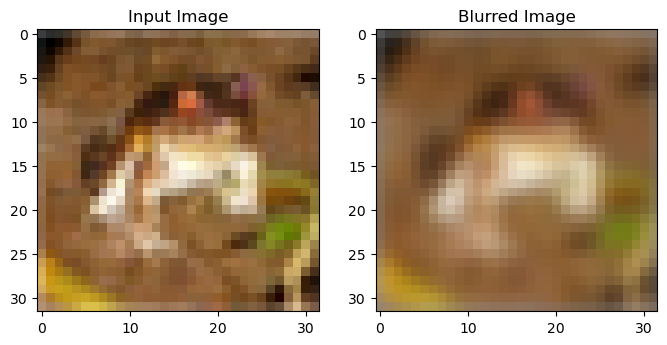

In [6]:
plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.imshow(x[0].reshape((3, 32, 32)).transpose(1, 2, 0)/2 +.5)
plt.title("Input Image")
plt.subplot(1, 2, 2)
plt.title("Blurred Image")
plt.imshow(y[0].reshape((3, 32, 32)).transpose(1, 2, 0)/2 +.5)
plt.show()

We run this notebook on a node of 8 GPUs, as is revealed in this call.

In [ ]:
jax.devices()

[CpuDevice(id=0)]

We introduce a simple convenience wrapper designed to shard the input point clouds `x` and `y` across those 8 GPUs. A more advanced sharding across multiple nodes can be easily carried out.

In [8]:
from jax.sharding import Mesh, NamedSharding, PartitionSpec as P

def shard_samples(x: jnp.ndarray) -> tuple[jnp.ndarray, NamedSharding]:
    num_devices = jax.device_count()
    devices = mesh_utils.create_device_mesh((num_devices,))
    mesh = Mesh(devices, axis_names=('batch',))
    sharding = NamedSharding(mesh, P('batch', None))
    
    return jax.device_put(x, sharding), sharding

The inputs are both sharded, and we store that sharding information.

In [ ]:
x_sharded, _ = shard_samples(x)
y_sharded, sharding = shard_samples(y)

The `run` function simply runs a Sinkhorn solver. The `batch_size` is left untouched, meaning the full cost matrix will be materialized but stored across multiple GPUs. If that `batch_size` argument was set to an integer, the cost matrix would be re-instantiated at each iteration, using blocks of `100k x batch_size`. This could be relevant for even bigger point clouds.

In [10]:
@functools.partial(jax.jit, static_argnames=('batch_size',), in_shardings=in_shardings)
def run(x: jnp.ndarray, 
        y: jnp.ndarray, 
        epsilon: Optional[float] = None,
        batch_size: Optional[int]=None) -> sinkhorn.SinkhornOutput:
    geom = pointcloud.PointCloud(
        x, y, cost_fn=costs.Dotp(),
        batch_size=batch_size,
        epsilon=epsilon,
        relative_epsilon="std")
    return linear.solve(geom)



Since the expected optimal coupling should be `I_n/n`, we simply compute to what extent the output of the Sinkhorn algorithm resembles that matrix. We extract its diagonal and compute its sum (should be close to 1 when using a small `epsilon`), or alternatively its generalized KL to `1_n/n`.

In [11]:
n = x.shape[0]
kls = []
sums = []
times = []
epsilons = 10**jnp.linspace(-1.5, 1, 10)  # Epsilon values from 1 to 100
# Run the Sinkhorn solver with different epsilon values
for epsilon in epsilons:
    start = time.time()
    out = run(x_sharded, y_sharded, epsilon)
    assert out.converged, "Sinkhorn did not converge in {} iterations".format(out.n_iters)
    times.append(time.time() - start)
    diag = out.diag
    kls.append(utils.gen_kl(jnp.ones((n,))/n, diag))
    sums.append(jnp.sum(diag))
  

These results are next summarized in a plot, displaying also running time as a function of `epsilon`.

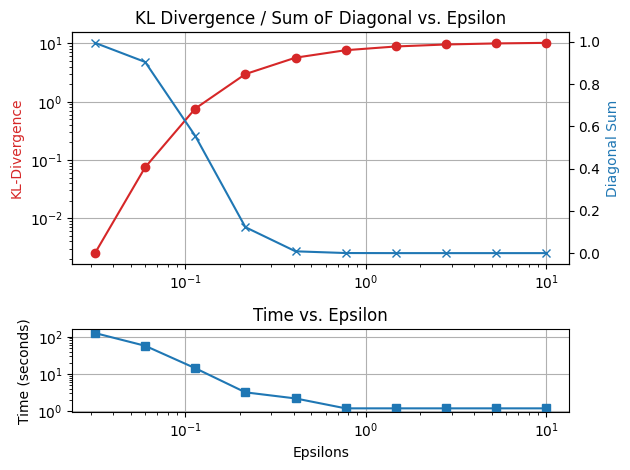

In [12]:
ax_met = plt.subplot2grid((3, 1), (0,0), rowspan=2)
ax_times = plt.subplot2grid((3, 1), (2,0))
color = 'tab:red'
ax_met.set_ylabel('KL-Divergence', color=color)
ax_met.plot(epsilons, kls, color=color, marker='o')

ax2 = ax_met.twinx()  # instantiate a second Axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Diagonal Sum', color=color) 
ax2.plot(epsilons, sums, color=color, marker='x')
# ax2.tick_params(axis='y', labelcolor=color)
ax_met.set_xscale('log')
ax_met.set_yscale('log')
ax_met.set_title('KL Divergence / Sum oF Diagonal vs. Epsilon')
ax_met.grid(True)

ax_times.plot(epsilons,times, marker='s')
ax_times.set_xlabel('Epsilons')
ax_times.set_ylabel('Time (seconds)')
ax_times.set_xscale('log')
ax_times.set_yscale('log')
ax_times.set_title('Time vs. Epsilon')
ax_times.grid(True)
plt.tight_layout()